## installing and importing

In [ ]:
!pip install streamlit pyngrok -q

In [ ]:
import time
import numpy as np
import gradio as gr
import pandas as pd
import seaborn as sns
from io import BytesIO
import matplotlib.pyplot as plt

sns.set()

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score,recall_score,precision_score

### reading data

In [ ]:
df = pd.read_excel('/content/Bank_Personal_Loan_Modelling.xlsx')

In [ ]:
df

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,s
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0,NaN
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0,NaN
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0,NaN
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0,NaN
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0,NaN
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0,NaN
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0,NaN
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0,NaN


## preprocessing

### checking for wrong datatypes

In [ ]:
df = df.drop(['ID', 's'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIP Code            5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal Loan       5000 non-null   int64  
 9   Securities Account  5000 non-null   int64  
 10  CD Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 507.9 KB



### nulls and duplecates


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.isnull().sum()

,0
Age,0
Experience,0
Income,0
ZIP Code,0
Family,0
CCAvg,0
Education,0
Mortgage,0
Personal Loan,0
Securities Account,0



### outliers

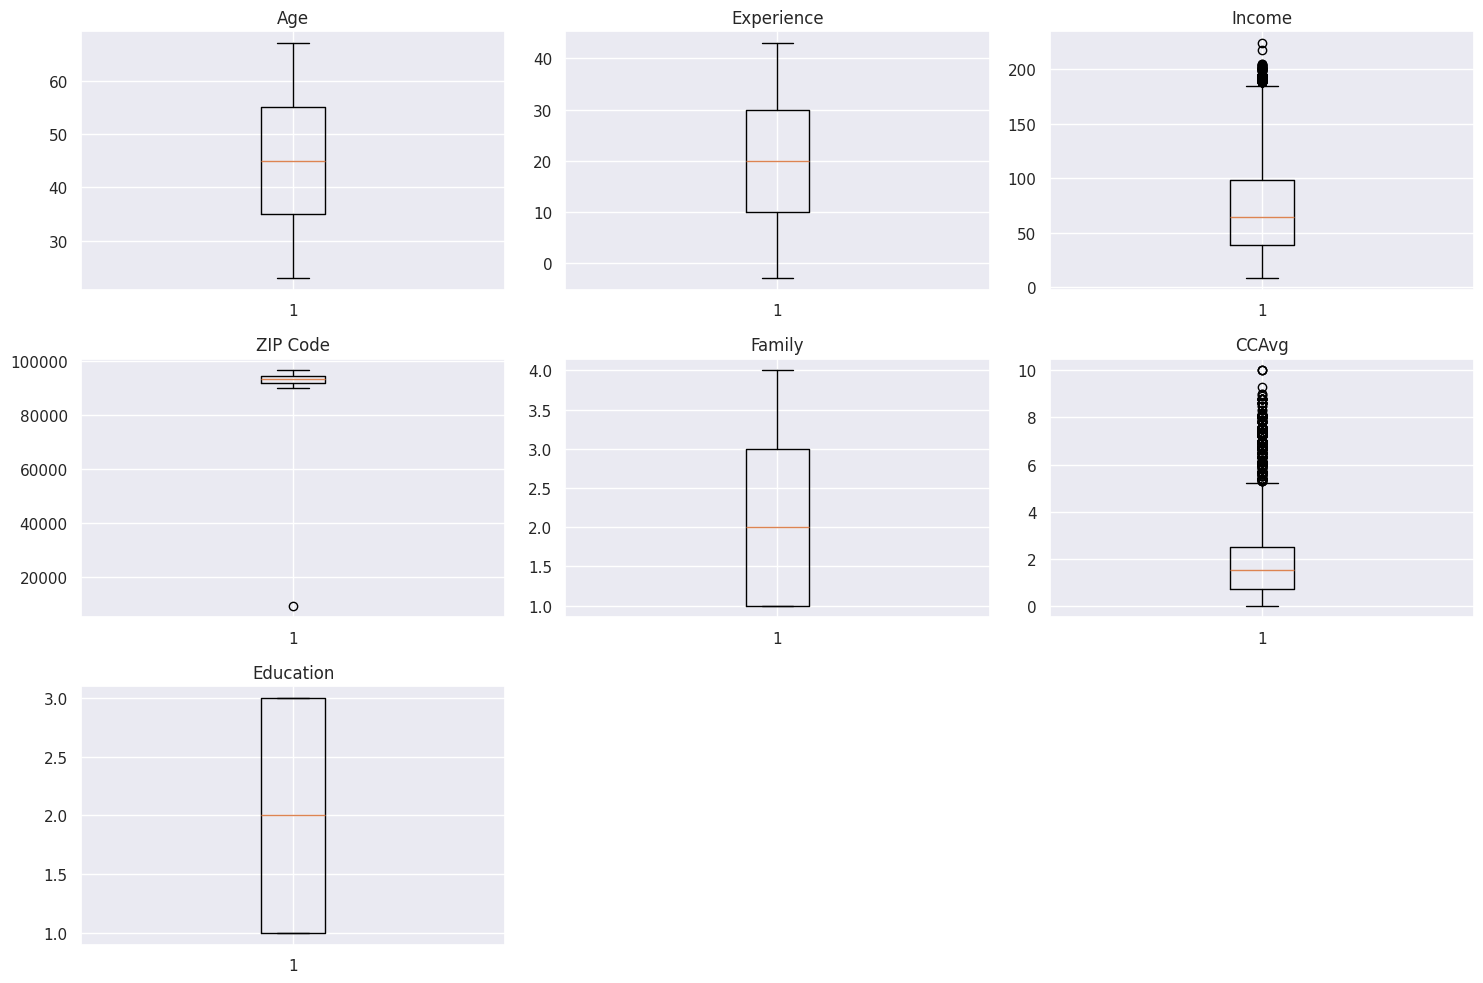

In [ ]:
columns = ['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg', 'Education']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(columns):
    axes[i].boxplot(df[column])
    axes[i].set_title(column)

for i in range(len(columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


### Correlation

In [ ]:
df.corr()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
Age,1.000000,0.994215,-0.055269,-0.029216,-0.046418,-0.052030,0.041334,-0.012539,-0.007726,-0.000436,0.008043,0.013702,0.007681
Experience,0.994215,1.000000,-0.046574,-0.028626,-0.052563,-0.050089,0.013152,-0.010582,-0.007413,-0.001232,0.010353,0.013898,0.008967
Income,-0.055269,-0.046574,1.000000,-0.016410,-0.157501,0.645993,-0.187524,0.206806,0.502462,-0.002616,0.169738,0.014206,-0.002385
ZIP Code,-0.029216,-0.028626,-0.016410,1.000000,0.011778,-0.004068,-0.017377,0.007383,0.000107,0.004704,0.019972,0.016990,0.007691
Family,-0.046418,-0.052563,-0.157501,0.011778,1.000000,-0.109285,0.064929,-0.020445,0.061367,0.019994,0.014110,0.010354,0.011588
CCAvg,-0.052030,-0.050089,0.645993,-0.004068,-0.109285,1.000000,-0.136138,0.109909,0.366891,0.015087,0.136537,-0.003620,-0.006686
Education,0.041334,0.013152,-0.187524,-0.017377,0.064929,-0.136138,1.000000,-0.033327,0.136722,-0.010812,0.013934,-0.015004,-0.011014
Mortgage,-0.012539,-0.010582,0.206806,0.007383,-0.020445,0.109909,-0.033327,1.000000,0.142095,-0.005411,0.089311,-0.005995,-0.007231
Personal Loan,-0.007726,-0.007413,0.502462,0.000107,0.061367,0.366891,0.136722,0.142095,1.000000,0.021954,0.316355,0.006278,0.002802
Securities Account,-0.000436,-0.001232,-0.002616,0.004704,0.019994,0.015087,-0.010812,-0.005411,0.021954,1.000000,0.317034,0.012627,-0.015028


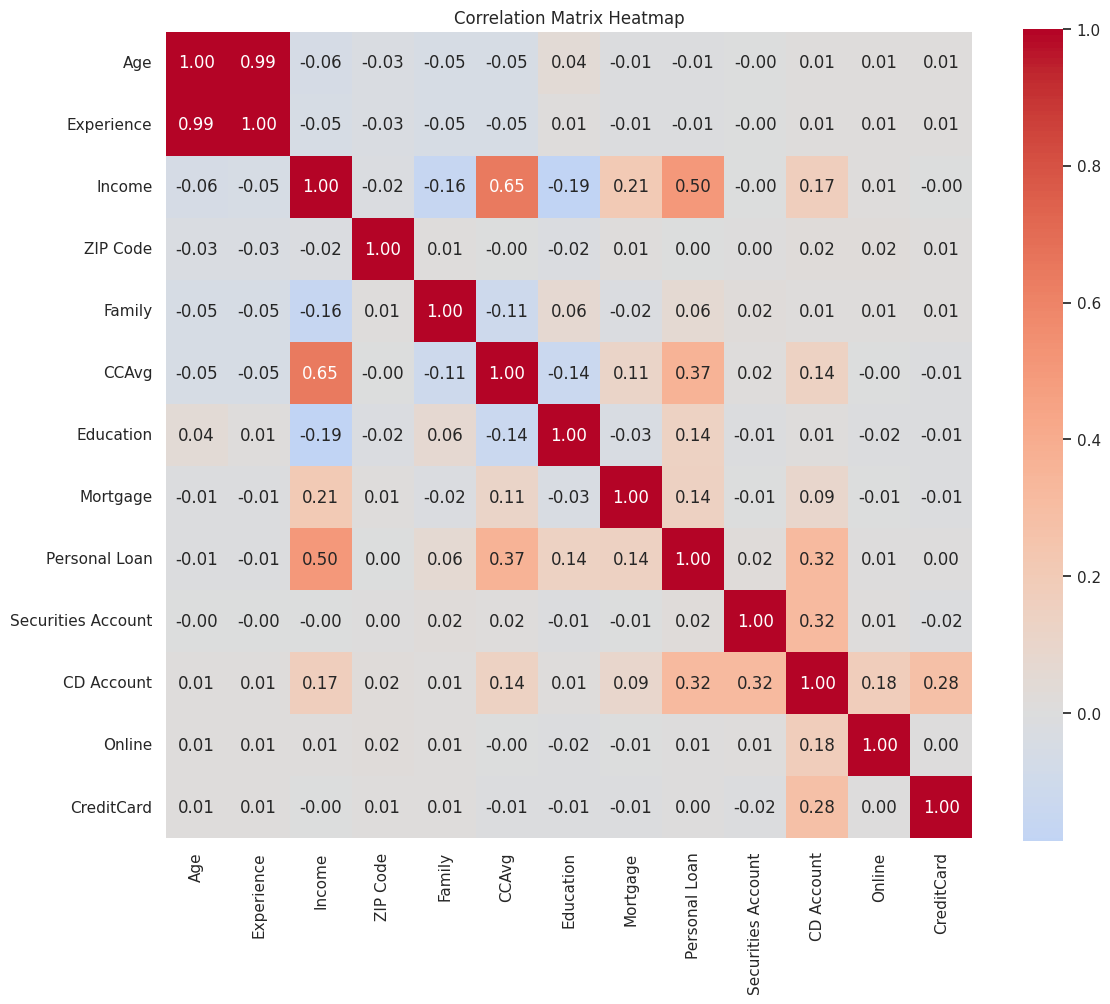

In [ ]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

In [ ]:
df = df.drop(columns=['Experience','ZIP Code'])
df

,Age,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,49,4,1.6,1,0,0,1,0,0,0
1,45,34,3,1.5,1,0,0,1,0,0,0
2,39,11,1,1.0,1,0,0,0,0,0,0
3,35,100,1,2.7,2,0,0,0,0,0,0
4,35,45,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4995,29,40,1,1.9,3,0,0,0,0,1,0
4996,30,15,4,0.4,1,85,0,0,0,1,0
4997,63,24,2,0.3,3,0,0,0,0,0,0
4998,65,49,3,0.5,2,0,0,0,0,1,0


### checking for values count  

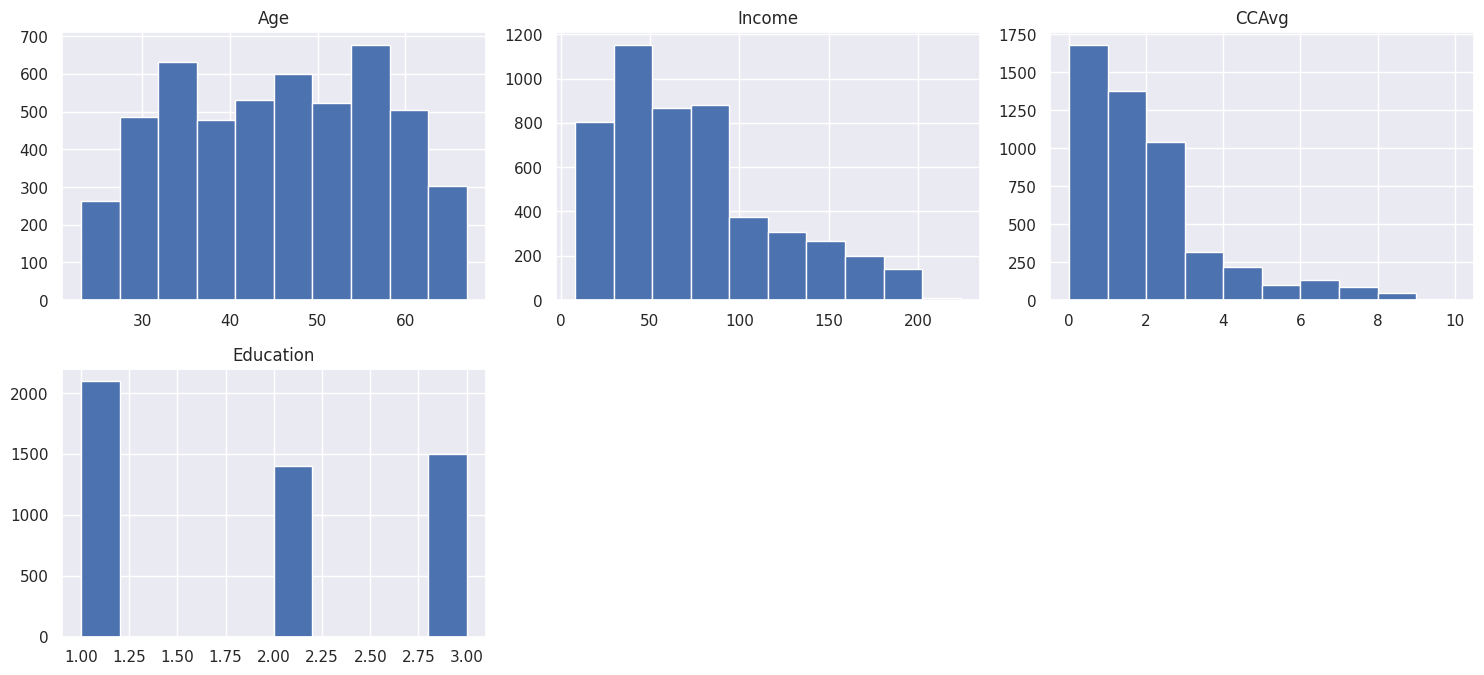

In [ ]:
columns = ['Age', 'Income', 'CCAvg', 'Education']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(columns):
    axes[i].hist(df[column])
    axes[i].set_title(column)

for i in range(len(columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
df['Family'].value_counts()

,count
Family,
1,1472
2,1296
4,1222
3,1010


### questions for visualization

Figure(1000x500)


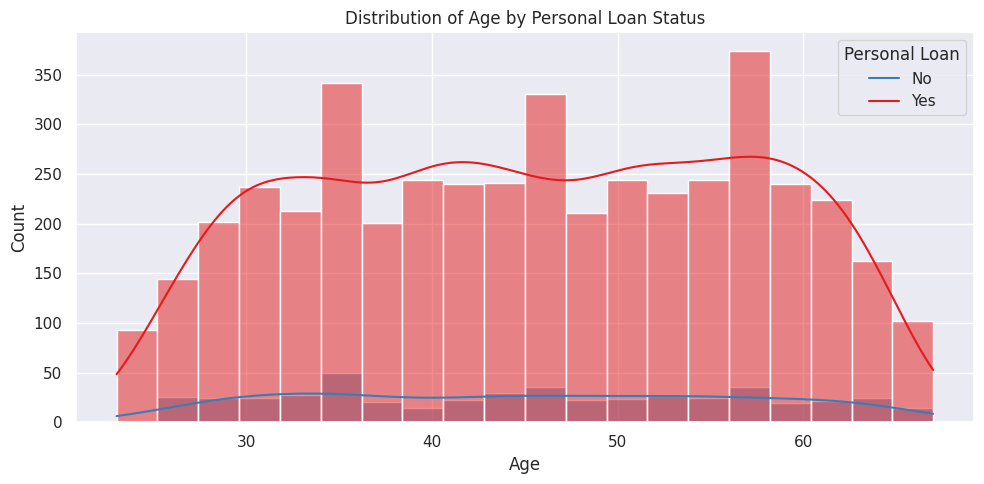

In [ ]:
# Which age group takes loans most frequently
def plot_age_distribution(df):
    fig = plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x='Age', hue='Personal Loan', kde=True, bins=20, palette='Set1')
    plt.title('Distribution of Age by Personal Loan Status')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.legend(title='Personal Loan', labels=['No', 'Yes'])
    plt.tight_layout()
    return fig

print(plot_age_distribution(df))

/tmp/ipython-input-121358655.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Family', y='Personal Loan', estimator='mean', ci=None, palette='Blues')
/tmp/ipython-input-121358655.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Family', y='Personal Loan', estimator='mean', ci=None, palette='Blues')


Figure(800x500)


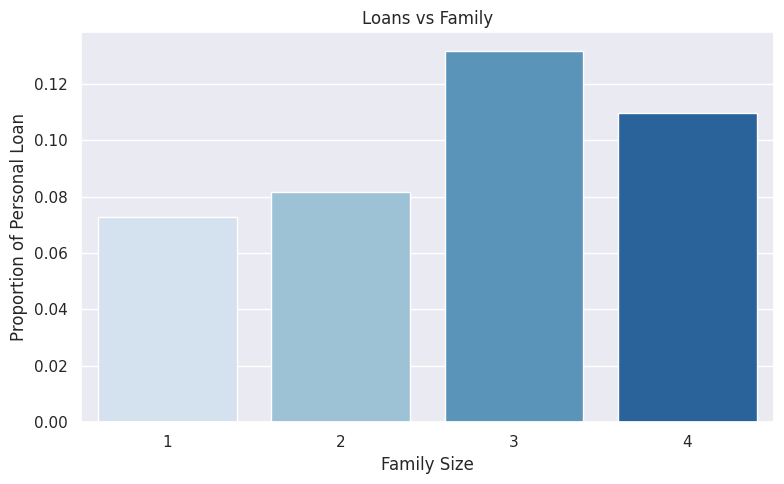

In [ ]:
# Do Larger Families Take More Loans
def plot_loans_by_family(df):
    fig = plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x='Family', y='Personal Loan', estimator='mean', ci=None, palette='Blues')
    plt.title('Loans vs Family')
    plt.xlabel('Family Size')
    plt.ylabel('Proportion of Personal Loan')
    plt.tight_layout()
    return fig

print(plot_loans_by_family(df))

Figure(1200x600)


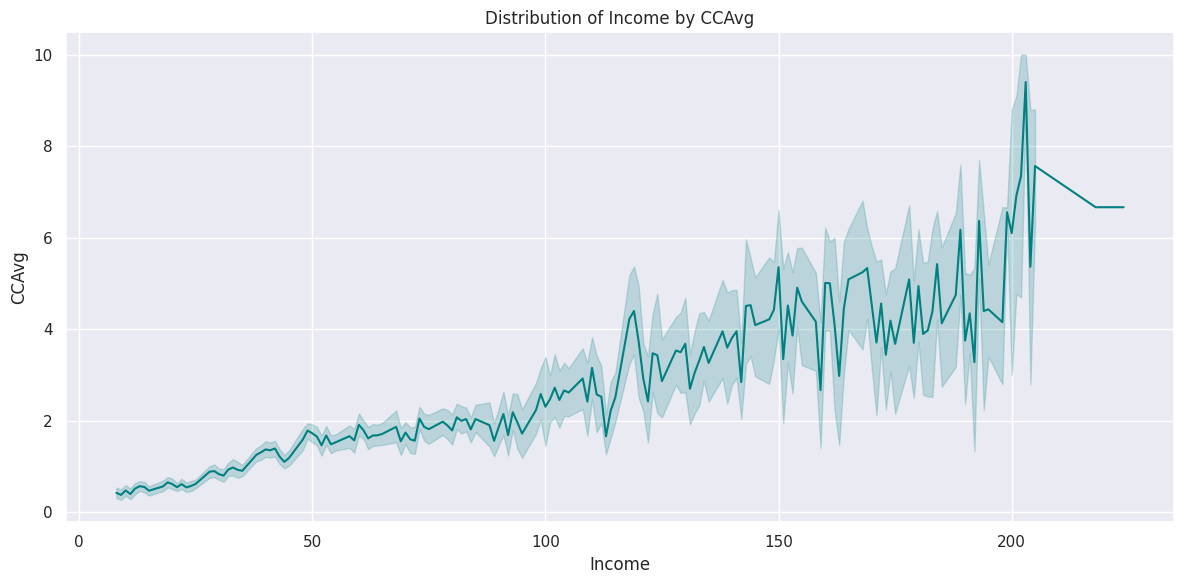

In [ ]:
#Do Higher-Income People Use Credit Cards More?
def plot_income_vs_ccavg(df):
    fig = plt.figure(figsize=(12, 6))  # Reduced from (50,15) to a more practical size for dashboards
    sns.lineplot(data=df, x='Income', y='CCAvg', color='teal')
    plt.title('Distribution of Income by CCAvg')
    plt.xlabel('Income')
    plt.ylabel('CCAvg')
    plt.tight_layout()
    return fig

print(plot_income_vs_ccavg(df))

/tmp/ipython-input-1581800342.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='CreditCard', y='Personal Loan', estimator='mean', ci=None, palette='pastel')
/tmp/ipython-input-1581800342.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='CreditCard', y='Personal Loan', estimator='mean', ci=None, palette='pastel')


Figure(800x500)


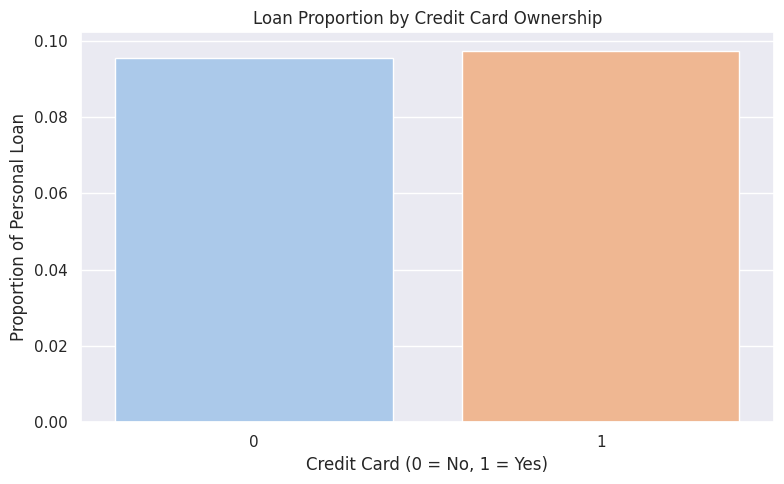

In [ ]:
# Does the majority of people who have a credit card take loans?
def plot_loan_by_creditcard(df):
    fig = plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x='CreditCard', y='Personal Loan', estimator='mean', ci=None, palette='pastel')
    plt.title('Loan Proportion by Credit Card Ownership')
    plt.xlabel('Credit Card (0 = No, 1 = Yes)')
    plt.ylabel('Proportion of Personal Loan')
    plt.tight_layout()
    return fig

print(plot_loan_by_creditcard(df))

Figure(800x500)


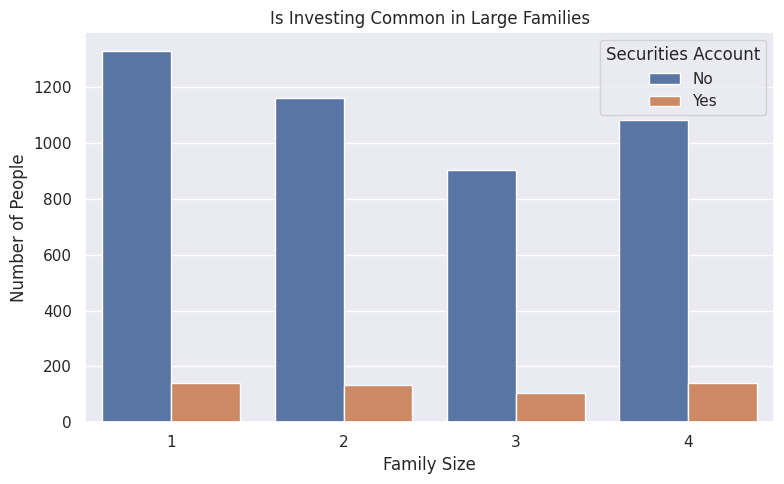

In [ ]:
#Do people who have a Securities Account usually have a large family
def plot_family_vs_securities(df):
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.countplot(x='Family', hue='Securities Account', data=df, ax=ax)

    ax.set_title('Is Investing Common in Large Families')
    ax.set_xlabel('Family Size')
    ax.set_ylabel('Number of People')
    ax.legend(title='Securities Account', labels=['No', 'Yes'])

    plt.tight_layout()
    return fig
print(plot_family_vs_securities(df))

Figure(600x400)


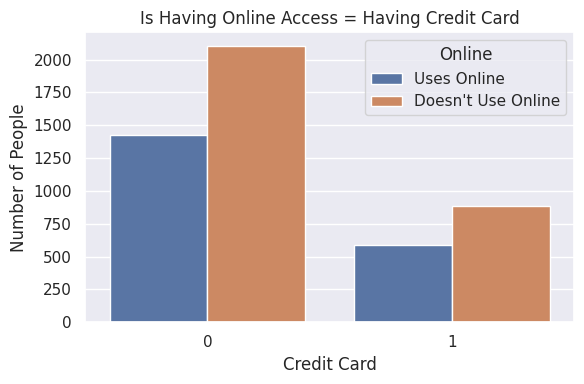

In [ ]:
# Is there a relationship between having online access and owning a credit card
def plot_family_vs_cd(df):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.countplot(x='CreditCard', hue='Online', data=df, ax=ax)

    ax.set_title('Is Having Online Access = Having Credit Card')
    ax.set_xlabel('Credit Card')
    ax.set_ylabel('Number of People')
    ax.legend(title="Online", labels=['Uses Online', "Doesn't Use Online"])
    plt.tight_layout()
    return fig
print(plot_family_vs_cd(df))

/tmp/ipython-input-1180420923.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CD Account', y='Personal Loan', data=df, palette='Set2', ax=ax)


Figure(600x400)


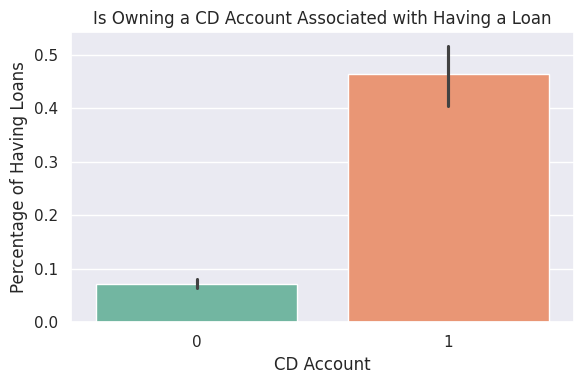

In [ ]:
# Is owning a CD account associated with having a loan
def plot_cd_vs_loan(df):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(x='CD Account', y='Personal Loan', data=df, palette='Set2', ax=ax)

    ax.set_title("Is Owning a CD Account Associated with Having a Loan")
    ax.set_xlabel("CD Account")
    ax.set_ylabel("Percentage of Having Loans")

    plt.tight_layout()
    return fig

print(plot_cd_vs_loan(df))

Figure(1200x600)


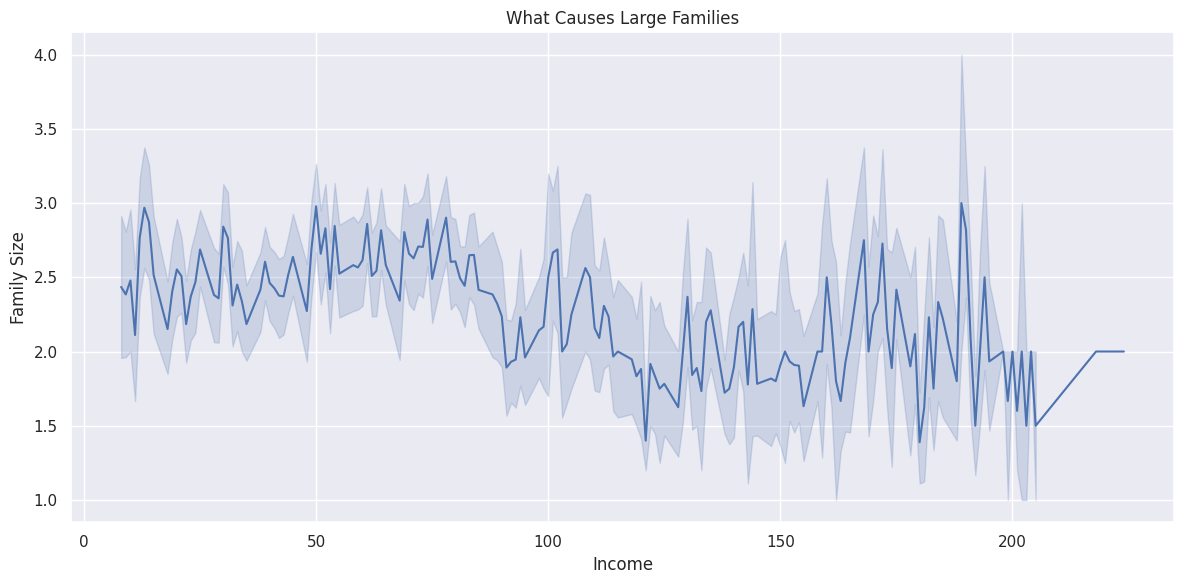

In [ ]:
# Does huge incomes causes large families
def plot_income_vs_family(df):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(x='Income', y='Family', data=df, ax=ax)

    ax.set_title('What Causes Large Families')
    ax.set_xlabel('Income')
    ax.set_ylabel('Family Size')

    plt.tight_layout()
    return fig
print(plot_income_vs_family(df))

Figure(800x500)


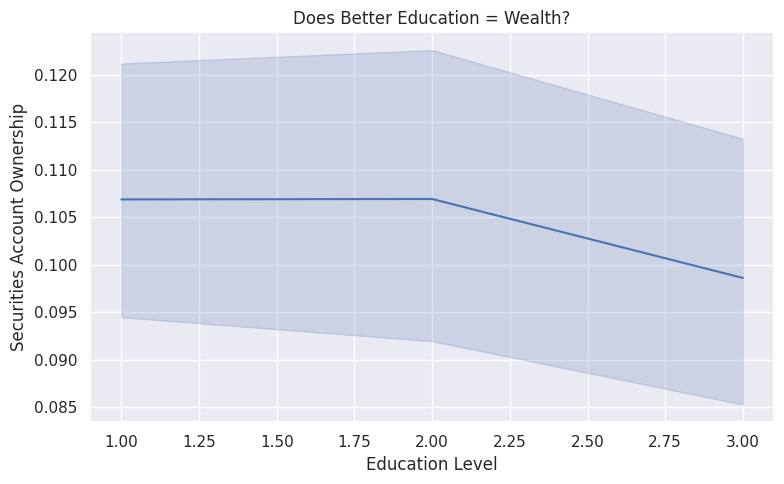

In [ ]:
# does education fast way to get rich
def plot_education_vs_income(df):
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.lineplot(data=df, x='Education', y='Securities Account', ax=ax)

    ax.set_title('Does Better Education = Wealth?')
    ax.set_xlabel('Education Level')
    ax.set_ylabel('Securities Account Ownership')

    plt.tight_layout()
    return fig
print(plot_education_vs_income(df))

/tmp/ipython-input-121358655.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Family', y='Personal Loan', estimator='mean', ci=None, palette='Blues')
/tmp/ipython-input-121358655.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Family', y='Personal Loan', estimator='mean', ci=None, palette='Blues')
/tmp/ipython-input-1581800342.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='CreditCard', y='Personal Loan', estimator='mean', ci=None, palette='pastel')
/tmp/ipython-input-1581800342.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.b

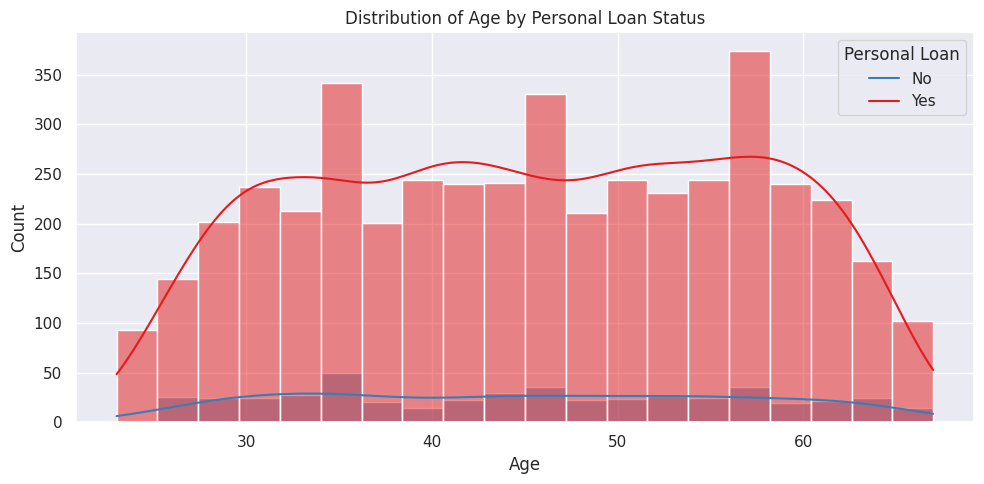

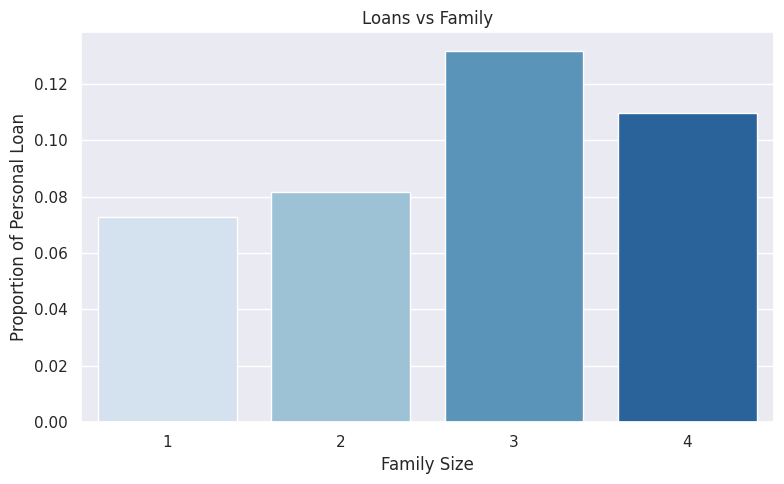

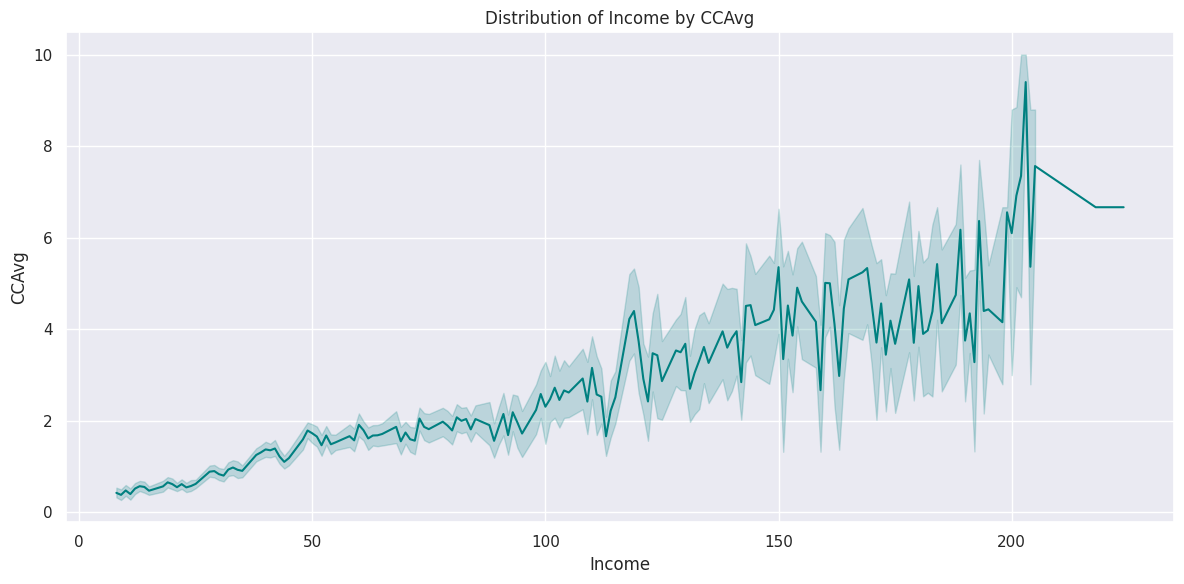

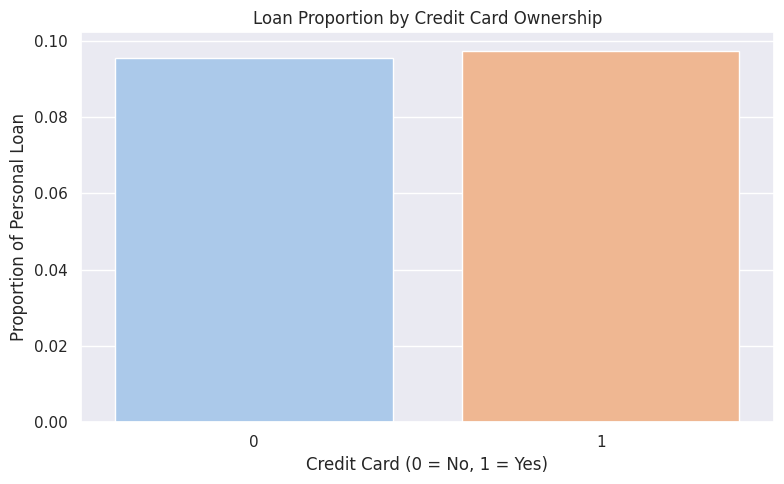

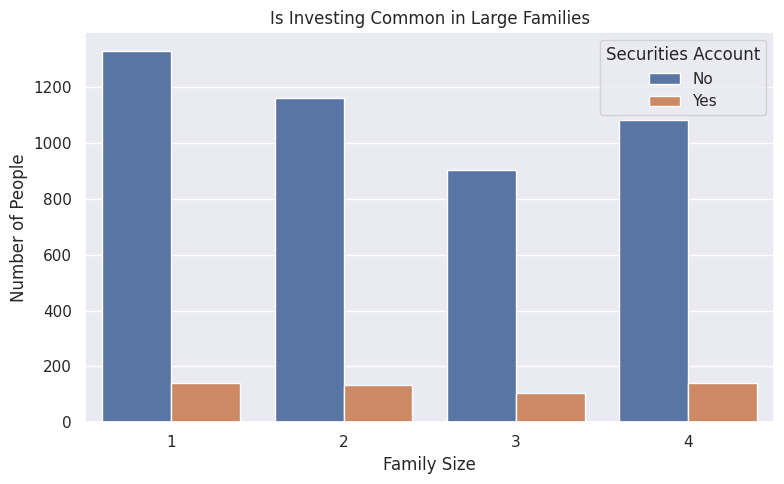

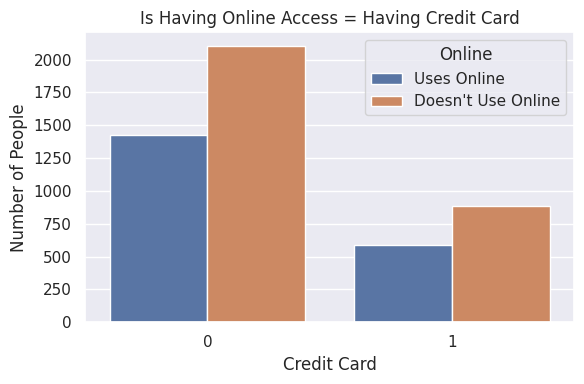

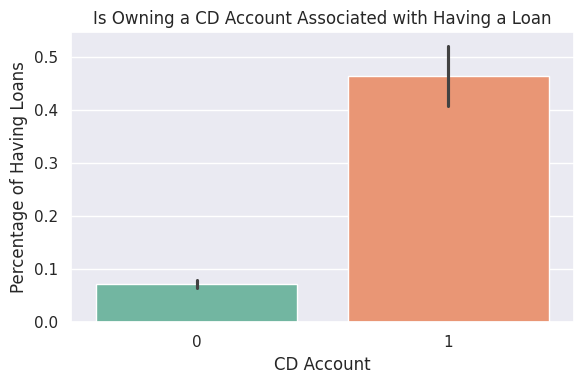

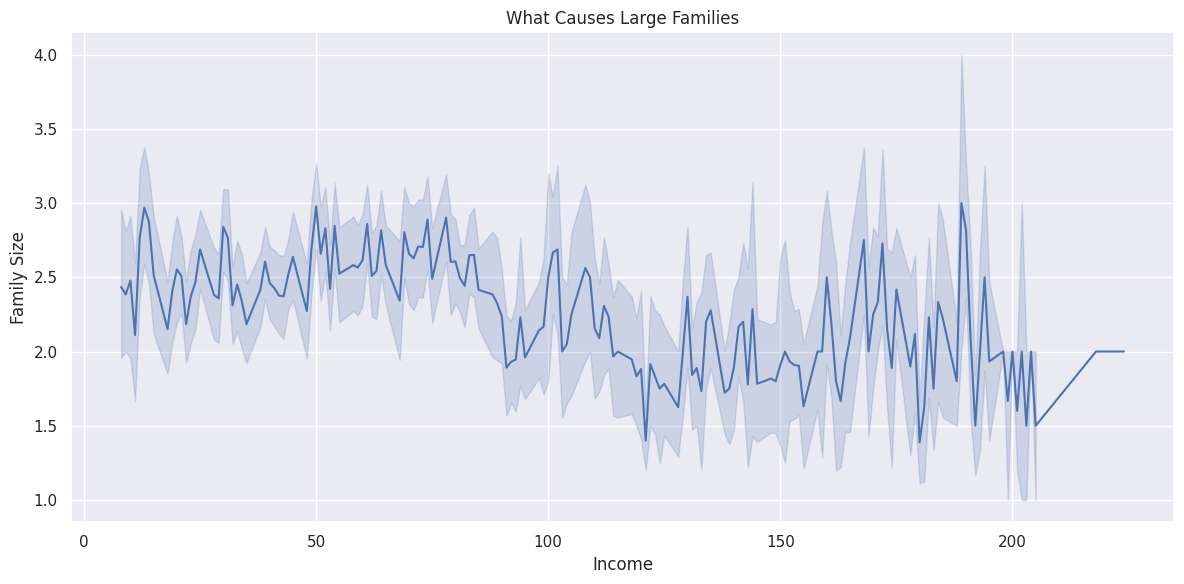

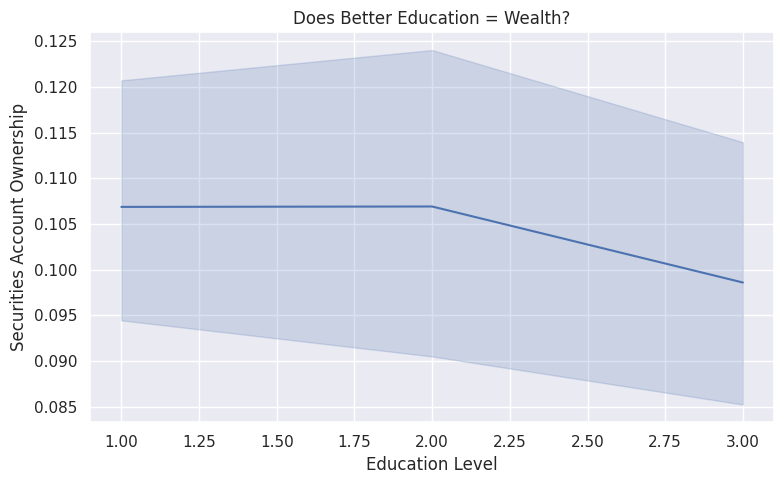

In [ ]:
plots = {
    "Age Distribution by Loan Status": plot_age_distribution(df),
    "Loans vs Family Size": plot_loans_by_family(df),
    "Income vs CCAvg": plot_income_vs_ccavg(df),
    "Loan Proportion by Credit Card Ownership": plot_loan_by_creditcard(df),
    "Is Investing Common in Large Families": plot_family_vs_securities(df),
    "Is having online access=having credit card": plot_family_vs_cd(df),
    "Is owning a CD account associated with having a loan": plot_cd_vs_loan(df),
    "what causes large families": plot_income_vs_family(df),
    "Does good education =wealthy": plot_education_vs_income(df),
}

## modeling

### training

In [ ]:
X = df[['Age','Income','Family','CCAvg','Education','Mortgage','Securities Account','CD Account','Online','CreditCard']]
y = df["Personal Loan"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### balancing

In [ ]:
df.groupby('Personal Loan').size()

,0
Personal Loan,
0,4520
1,480


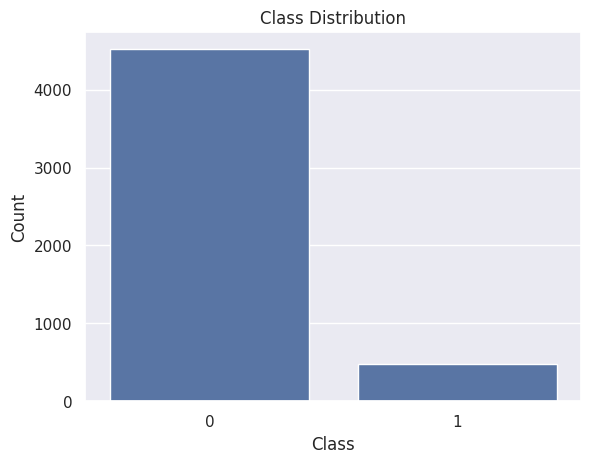

In [ ]:
sns.countplot(x="Personal Loan", data=df)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
value_counts = pd.Series(y_train_bal).value_counts()
print("Distribution after SMOTE:")
print(value_counts)

Distribution after SMOTE:
Personal Loan
0    3616
1    3616
Name: count, dtype: int64


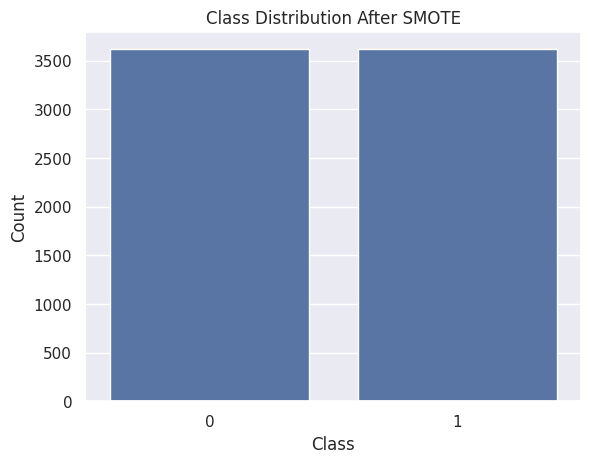

In [ ]:
sns.countplot(x=y_train_bal)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
models = {
    "Logistic Regression": (LogisticRegression(), {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs'],
        'penalty': ['l2']
    }),
    "Random Forest": (RandomForestClassifier(), {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5]
    }),
    "KNN": (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }),
    "SVM": (SVC(probability=True), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }),
    "Decision Tree": (
        DecisionTreeClassifier(),
        {
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5]
        }
    ),

    "Naive Bayes" :(
        GaussianNB(),{}
    ),

    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.05, 0.1]
        }
    )
}

### best model

In [ ]:
best_models = {}
model_scores = {}
results = {}

comparison_table = []

for name, (model, params) in models.items():
    print(f"Training {name}...")
    start_time = time.time()

    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_bal, y_train_bal)

    training_time = time.time() - start_time

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    best_models[name] = best_model
    model_scores[name] = acc
    results[name] = {
        "model": best_model,
        "accuracy": acc,
        "report": report,
        "y_pred": y_pred,
        "conf_matrix": cm,
        "time": training_time
    }

    comparison_table.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "Time (s)": training_time
    })

comparison_df = pd.DataFrame(comparison_table)
comparison_df = comparison_df.sort_values(by="Accuracy", ascending=False)

best_model_name = max(model_scores, key=model_scores.get)
best_score = model_scores[best_model_name]

Training Logistic Regression...
Training Random Forest...
Training KNN...
Training SVM...
Training Decision Tree...
Training Naive Bayes...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:45:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## deployment


In [ ]:
def show_model_evaluation(model_name):
    res = results[model_name]

    acc = f"{res['accuracy']:.2f}"
    train_acc = f"{res['model'].score(X_train_scaled, y_train):.2f}"
    test_acc = f"{res['model'].score(X_test_scaled, y_test):.2f}"

    report_df = pd.DataFrame(res["report"]).transpose().reset_index()

    y_pred = res["y_pred"]

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{model_name} - Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    return acc,train_acc,test_acc, report_df, fig

In [ ]:
def clean_params(params):
    return {k: v for k, v in params.items() if v is not None and v != 'deprecated'}

def predict_loan_status(*inputs):
    input_df = pd.DataFrame([inputs], columns=X.columns)

    input_scaled = scaler.transform(input_df)

    prediction = best_model.predict(input_scaled)[0]
    return "Approved ✅" if prediction == 1 else "Rejected ❌"


### interface

/usr/local/lib/python3.11/dist-packages/gradio/utils.py:1054: UserWarning: Expected 1 arguments for function <function show_model_evaluation at 0x7e140b92b6a0>, received 0.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/utils.py:1058: UserWarning: Expected at least 1 arguments for function <function show_model_evaluation at 0x7e140b92b6a0>, received 0.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e439ca18cbb925c40d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


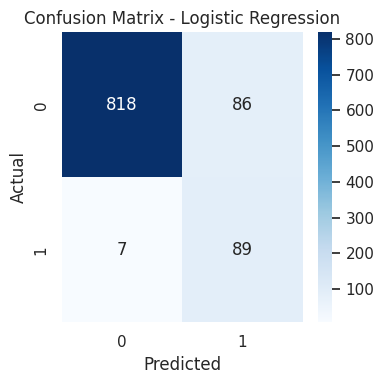

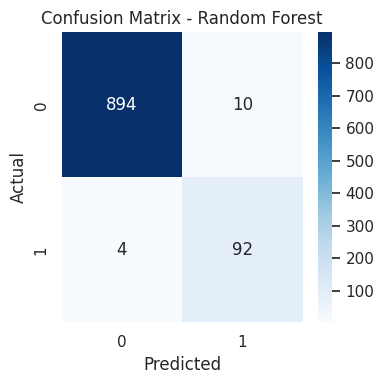

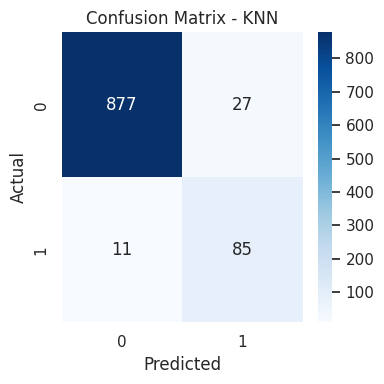

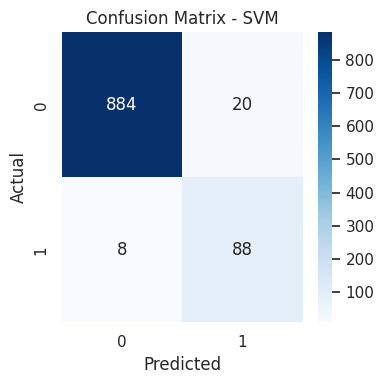

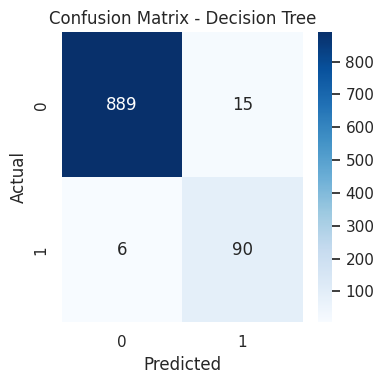

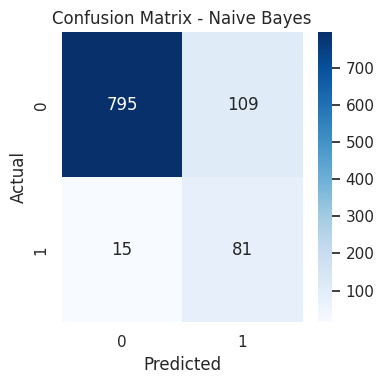

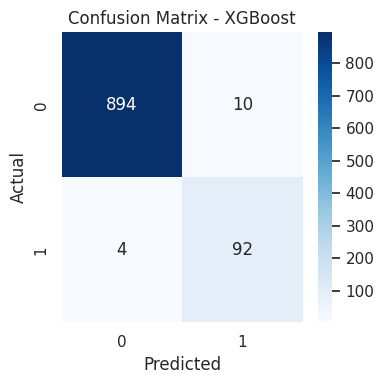

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("<div align='center'><h1>🏦 Loan Classification Dashboard</h1></div>")

    with gr.Tabs():
        with gr.Tab("📁 Dataset Overview"):
            gr.Dataframe(value=df)
            gr.Textbox(label="Dataset Size", value=str(df.shape))

        with gr.Tab("📊 Exploratory Data Analysis"):
            gr.Markdown("<div align='center'><h2>📊 EDA</h2></div>")

            for title, plot in plots.items():
                  gr.Markdown(f"## {title}")
                  gr.Plot(plot)


        with gr.Tab("✅ Best Model Overview"):
          gr.Markdown("## ✅ Best Model Overview")
          gr.Markdown(f"**Best Model:** `{best_model_name}`")
          gr.Markdown(f"**Accuracy:** `{model_scores[best_model_name]:.2f}`")

          for name in results:
              cm = results[name]["conf_matrix"]
              model_time = results[name]["time"]

              fig, ax = plt.subplots(figsize=(4, 4))
              sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
              ax.set_title(f'Confusion Matrix - {name}')
              ax.set_xlabel("Predicted")
              ax.set_ylabel("Actual")
              plt.tight_layout()

              gr.Markdown(f"### ⏱️ {name} - Training Time: `{model_time:.2f} sec`")
              gr.Plot(fig)

        with gr.Tab("📈 Evaluate Any Model"):
            gr.Markdown("## 🔍 Evaluate Any Model")
            model_dropdown = gr.Dropdown(choices=list(results.keys()), value=best_model_name, label="Select a Model")

            accuracy_box = gr.Textbox(label="Accuracy")
            test_acc_box = gr.Textbox(label="Test Accuracy")
            train_acc_box = gr.Textbox(label="Train Accuracy")
            report_df = gr.Dataframe(label="Classification Report")
            cm_plot = gr.Plot(label="Confusion Matrix")

            model_dropdown.change(
                fn=show_model_evaluation,
                inputs=model_dropdown,
                outputs=[accuracy_box, test_acc_box, train_acc_box, report_df, cm_plot]
            )

            demo.load(
                fn=show_model_evaluation,
                inputs=[],
                outputs=[accuracy_box, test_acc_box, train_acc_box, report_df, cm_plot],
                queue=False
            )

        with gr.Tab("🤖 Predict Loan Status"):
            gr.Markdown("<div align='center'><h2>🧠Predict Loan Status🧠</h2></div>")

            with gr.Row():
                input_widgets = []
                for col in X.columns:
                    input_widgets.append(gr.Number(label=col))

            predict_btn = gr.Button("Predict")
            prediction_output = gr.Textbox(label="Prediction")

            predict_btn.click(fn=predict_loan_status, inputs=input_widgets, outputs=prediction_output)

demo.launch()